In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('website_traffic.csv')
df.head()

,traffic
0,932
1,929
2,938
3,964
4,990


<AxesSubplot:>

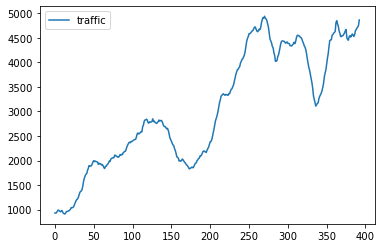

In [3]:
df.plot()

### Pre-processing Data

<AxesSubplot:>

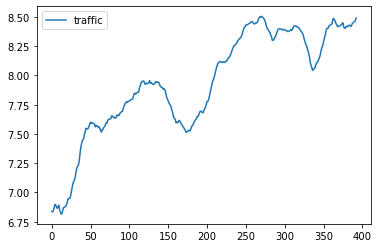

In [4]:
# transform data using log algorithm
df = np.log(df)
df.plot()

In [5]:
# split training and testing data
# using the last 30 days for testing
df_train = df[:-30]
df_test = df[-30:]

### Check for Stationarity

#### Method #1: Time Series Plot

For this example, it's easy to tell that the series is non-stationary from the above plot.

#### Method #2: ADF Test

In [8]:
from statsmodels.tsa.stattools import adfuller
dftest = adfuller(df_train, autolag = 'AIC')

In [10]:
print(f'ADF Statistic: {dftest[0]}')
print(f'p-value: {dftest[1]}')
print(f'Number of Lags: {dftest[2]}')
for key, value in dftest[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -2.186901700189855
p-value: 0.21103368370690634
Number of Lags: 17
Critial Values:
   1%, -3.447909006729481
Critial Values:
   5%, -2.8692783343881483
Critial Values:
   10%, -2.5708923751111112


The p-value is greater than the significance level of 0.05 and hence we cannot reject the null hypothesis, which means the series is non-stationary.

### Transforming to Stationary by Differencing

<AxesSubplot:>

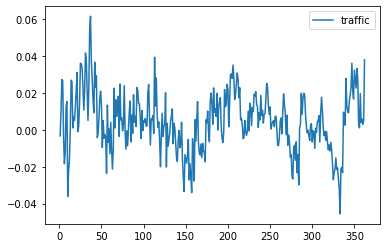

In [13]:
df_train_diff = df_train.diff().dropna()
df_train_diff.plot()

In [14]:
dftest = adfuller(df_train_diff, autolag = 'AIC')
print(f'p-value: {dftest[1]}')

p-value: 0.022059461239126298


The p value shows that after the 1st order differencing, the transformed data is stationary. Hence, we could set the d=1 in ARIMA model.

### ARIMA Model

In [49]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(df_train, order=(0,1,1))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                traffic   No. Observations:                  363
Model:                 ARIMA(0, 1, 1)   Log Likelihood                1042.366
Date:                Sat, 06 Jan 2024   AIC                          -2080.732
Time:                        20:55:05   BIC                          -2072.949
Sample:                             0   HQIC                         -2077.638
                                - 363                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.4959      0.045     10.993      0.000       0.407       0.584
sigma2         0.0002   1.35e-05     13.724      0.000       0.000       0.000
Ljung-Box (L1) (Q):                  12.45   Jarque-

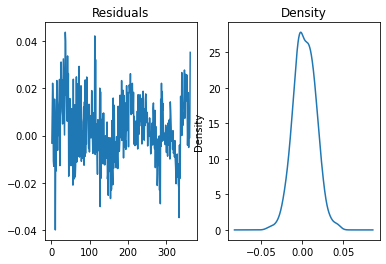

In [50]:
residuals = model_fit.resid[1:]
fig, ax = plt.subplots(1,2)
residuals.plot(title='Residuals', ax=ax[0])
residuals.plot(title='Density', kind='kde', ax=ax[1])
plt.show()

<AxesSubplot:>

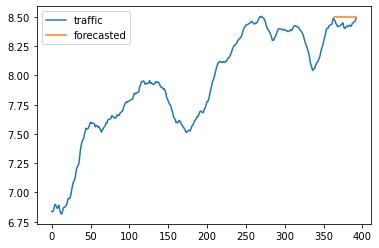

In [51]:
pred = model_fit.forecast(len(df_test))
df['forecasted'] = [None]*len(df_train) + list(pred)
df.plot()

### Auto ARIMA Model

In [54]:
import pmdarima as pm

In [55]:
auto_arima = pm.auto_arima(df_train, stepwise=False, seasonal=False)
auto_arima

ARIMA(order=(5, 1, 0), scoring_args={}, suppress_warnings=True)

In [56]:
auto_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  363
Model:               SARIMAX(5, 1, 0)   Log Likelihood                1107.360
Date:                Sat, 06 Jan 2024   AIC                          -2200.719
Time:                        20:58:28   BIC                          -2173.478
Sample:                             0   HQIC                         -2189.890
                                - 363                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0009      0.001      1.512      0.131      -0.000       0.002
ar.L1          0.5213      0.052      9.977      0.000       0.419       0.624
ar.L2          0.0934      0.065      1.434      0.151      -0.034       0.221
ar.L3         -0.0362      0.064     -0.565      0.572      -0.162       0.090
ar.L4          0.1282      0.053      2.418      0.016       0.024       0.232
ar.L5          0.1018      0.049      2.063      0.039       0.005       0.199
sigma2         0.0001   8.59e-06     14.962      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                11.86
Prob(Q):                              0.91   Prob(JB):                         0.00
Heteroskedasticity (H):               0.54   Skew:                             0.23
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.76
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<AxesSubplot:>

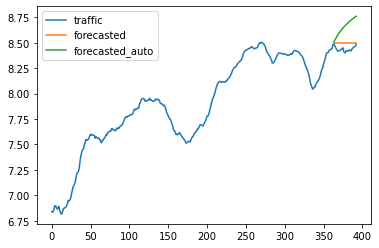

In [57]:
pred_auto = auto_arima.predict(n_periods=len(df_test))
df['forecasted_auto'] = [None]*len(df_train) + list(pred_auto)
df.plot()

In [58]:
from sklearn.metrics import mean_squared_error
print(f'mean squared error of mannual ARIMA model is: {mean_squared_error(df_test, pred)}')
print(f'mean squared error of auto ARIMA model is: {mean_squared_error(df_test, pred_auto)}')

mean squared error of mannual ARIMA model is: 0.0041740325393914155
mean squared error of auto ARIMA model is: 0.05347257128522675
